In [28]:

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from pathlib import Path
import pandas as pd

In [29]:
path = Path("/Users/jaimesastrecrespo/DAFT_1022/Final_project/spotify_App")

In [30]:
with open(path / "client_s.txt") as f:
    content = f.readlines()
content = [x.strip() for x in content]


In [31]:
client_id = content[0]
client_secret = content[1]
redirect_uri = 'http://127.0.0.1:8080/yep'
username = content[3]


In [32]:
scope = "user-library-read user-read-recently-played user-top-read playlist-modify-public playlist-read-private playlist-read-collaborative"


In [33]:

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, 
                                                      client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [34]:
token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [35]:
results_fav_songs = sp.current_user_top_tracks(limit = 50,offset=0,time_range='short_term')

In [36]:
from spotifuncs import create_df_top_songs, append_audio_features , authenticate, create_df_recommendations

In [37]:
top_tracks_short = sp.current_user_top_tracks(limit = 50,offset=0,time_range='short_term')
top_tracks_med = sp.current_user_top_tracks(limit = 50,offset=0,time_range='medium_term')
top_tracks_long = sp.current_user_top_tracks(limit = 50,offset=0,time_range='long_term')

#combine the top_tracks
top_tracks_short_df = append_audio_features(create_df_top_songs(top_tracks_short),sp)
top_tracks_med_df = append_audio_features(create_df_top_songs(top_tracks_med),sp)
top_tracks_long_df = append_audio_features(create_df_top_songs(top_tracks_long),sp)

top_tracks_short_df["Timeframe"] = "short term"
top_tracks_med_df["Timeframe"] = "medium term"
top_tracks_long_df["Timeframe"] = "long term"

top_tracks = pd.concat([top_tracks_short_df, top_tracks_med_df, top_tracks_long_df])
top_tracks = top_tracks.reset_index(drop = True)


In [38]:
top_tracks

,track_name,album,track_id,artist,duration,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Timeframe
0,Everlong,The Colour And The Shape,5UWwZ5lm5PKu6eKsHAGxOk,Foo Fighters,250546,83,0.413,0.881,11,-5.541,0,0.0367,0.000060,0.000308,0.0805,0.364,158.066,short term
1,My Hero,The Colour And The Shape,4dVbhS6OiYvFikshyaQaCN,Foo Fighters,260026,75,0.398,0.927,9,-4.212,1,0.0567,0.000062,0.000177,0.0575,0.311,77.106,short term
2,MAN ON THE MOON,TM,3UdquFlgsSBKueNRHgjOiG,BROCKHAMPTON,240600,64,0.736,0.737,7,-7.726,1,0.0437,0.073200,0.631000,0.1090,0.534,145.006,short term
3,Best of You,In Your Honor,5FZxsHWIvUsmSK1IAvm2pp,Foo Fighters,255626,75,0.366,0.940,1,-5.119,0,0.0696,0.000769,0.000094,0.1880,0.369,130.198,short term
4,No L's,Luv 4 Rent,12CNybio0Bxean3F3uYugU,Smino,175018,68,0.786,0.650,1,-6.472,1,0.3100,0.156000,0.000000,0.1270,0.492,130.993,short term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Rockadown Subway Session,Rockadown Subway Session,3bdhZxL276JwNlNsQgu51s,Vanupié,214041,0,0.650,0.648,6,-6.694,0,0.3390,0.525000,0.000000,0.6830,0.792,140.607,long term
146,Je veux,Zaz,734dz1YaFITwawPpM25fSt,Zaz,215933,68,0.525,0.807,2,-6.366,0,0.0725,0.251000,0.000000,0.0504,0.741,155.397,long term
147,Redemption Song,Uprising,26PwuMotZqcczKLHi4Htz3,Bob Marley & The Wailers,233560,69,0.671,0.256,7,-10.743,1,0.0387,0.608000,0.000000,0.0737,0.694,115.871,long term
148,Last Kiss,Last Kiss,0QnONzv3TvHAWk294h6DaQ,Pearl Jam,195466,71,0.622,0.692,7,-6.970,1,0.0276,0.363000,0.000158,0.1930,0.774,112.053,long term


### Recommendation 

In [39]:
seed_tracks = top_tracks["track_id"].tolist()

In [40]:
len(seed_tracks)

150

The SpotifyAPI only accepts a small list of seed tracks for each query which is unfortunate as I wanted to use the whole playlit as a seed for the recommendations. I worked around this by using "packages" of 5 seed tracks to retrieve 25 recommendations (basically 5 per song).

In [41]:
sp_m = authenticate(redirect_uri, client_credentials_manager, username, scope, client_id, client_secret)


In [42]:
recomm_dfs = []
for i in range(5,len(seed_tracks)+1,5):
    recomms = sp_m.recommendations(seed_tracks = seed_tracks[i-5:i],limit = 10)
    recomms_df = append_audio_features(create_df_recommendations(recomms),sp_m)
    recomm_dfs.append(recomms_df)
recomms_df = pd.concat(recomm_dfs)
recomms_df.reset_index(drop = True, inplace = True)

In [43]:

recomms_df

,track_name,album,track_id,artist,duration,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Outside,Break the Cycle,50Re2bLgXqG9qN7v2QHNTm,Staind,293133,62,0.515,0.594,1,-4.708,1,0.0262,0.008440,0.006580,0.0752,0.218,146.564
1,Plug in Baby,Origin of Symmetry,2UKARCqDrhkYDoVR4FN5Wi,Muse,218000,66,0.408,0.965,2,-4.232,1,0.0500,0.000007,0.000402,0.1100,0.349,136.018
2,Open Up Your Eyes,Lemon Parade,0DRh0T7UkzpnjoKtU6zVod,Tonic,220493,53,0.438,0.910,7,-6.476,1,0.0487,0.006370,0.000056,0.0930,0.319,98.698
3,OLD NEWS (feat. Baird),"ROADRUNNER: NEW LIGHT, NEW MACHINE",1Ib6RGb1Wmdl0r7D9PY36i,BROCKHAMPTON,193560,43,0.458,0.609,8,-5.737,1,0.0800,0.098100,0.000000,0.2550,0.557,84.175
4,VERIZON,NOIR,7KlM4piqWaxB69tvnhlrns,Smino,207825,41,0.826,0.397,7,-8.434,1,0.3540,0.169000,0.010300,0.1290,0.155,130.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,La foule,de l'accordeoniste a milord,2xZfPZxInlDXDKc6NDts8Z,Édith Piaf,178840,59,0.478,0.389,4,-8.540,0,0.0546,0.779000,0.000007,0.1930,0.610,89.765
296,C'est bien mieux comme ça,D'ici et d'ailleurs,70cjQvFMIDyX2eYyhxect0,Soha,252040,42,0.687,0.651,4,-9.837,0,0.0644,0.116000,0.003360,0.3800,0.526,169.976
297,Comfortably Numb,The Wall,5HNCy40Ni5BZJFw1TKzRsC,Pink Floyd,382296,73,0.472,0.366,11,-12.595,0,0.0286,0.150000,0.312000,0.0837,0.171,127.163
298,Brand New Start,Modern Classics - The Greatest Hits,6QVFyh4FrTQt518kZwC7QH,Paul Weller,246400,40,0.612,0.489,7,-9.377,1,0.0230,0.069400,0.000872,0.2270,0.391,92.783


In [49]:
sp_m.user_playlist_add_tracks(username,
                              playlist_id="spotify:playlist:6RhKE7bpPNxBuSGla125Ql",
                              tracks = recomms_df["track_id"].tolist()[:100])


{'snapshot_id': 'NSw5YzVmMTYyMDRmNzAzM2Y3MzI2Y2U4ODVmODZhNjkxMmZiNmVhNGI5'}

99

In [48]:
top_tracks.drop_duplicates()

,track_name,album,track_id,artist,duration,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Timeframe
0,Everlong,The Colour And The Shape,5UWwZ5lm5PKu6eKsHAGxOk,Foo Fighters,250546,83,0.413,0.881,11,-5.541,0,0.0367,0.000060,0.000308,0.0805,0.364,158.066,short term
1,My Hero,The Colour And The Shape,4dVbhS6OiYvFikshyaQaCN,Foo Fighters,260026,75,0.398,0.927,9,-4.212,1,0.0567,0.000062,0.000177,0.0575,0.311,77.106,short term
2,MAN ON THE MOON,TM,3UdquFlgsSBKueNRHgjOiG,BROCKHAMPTON,240600,64,0.736,0.737,7,-7.726,1,0.0437,0.073200,0.631000,0.1090,0.534,145.006,short term
3,Best of You,In Your Honor,5FZxsHWIvUsmSK1IAvm2pp,Foo Fighters,255626,75,0.366,0.940,1,-5.119,0,0.0696,0.000769,0.000094,0.1880,0.369,130.198,short term
4,No L's,Luv 4 Rent,12CNybio0Bxean3F3uYugU,Smino,175018,68,0.786,0.650,1,-6.472,1,0.3100,0.156000,0.000000,0.1270,0.492,130.993,short term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Rockadown Subway Session,Rockadown Subway Session,3bdhZxL276JwNlNsQgu51s,Vanupié,214041,0,0.650,0.648,6,-6.694,0,0.3390,0.525000,0.000000,0.6830,0.792,140.607,long term
146,Je veux,Zaz,734dz1YaFITwawPpM25fSt,Zaz,215933,68,0.525,0.807,2,-6.366,0,0.0725,0.251000,0.000000,0.0504,0.741,155.397,long term
147,Redemption Song,Uprising,26PwuMotZqcczKLHi4Htz3,Bob Marley & The Wailers,233560,69,0.671,0.256,7,-10.743,1,0.0387,0.608000,0.000000,0.0737,0.694,115.871,long term
148,Last Kiss,Last Kiss,0QnONzv3TvHAWk294h6DaQ,Pearl Jam,195466,71,0.622,0.692,7,-6.970,1,0.0276,0.363000,0.000158,0.1930,0.774,112.053,long term


In [ ]:
#top_tracks.to_csv("my_spotify_2022.csv", sep = ',')

### Average Audio Features for the three Timeframes

I wanted to explore the average audio feature of my top tracks to get a kind of "top track profile" I also wanted to see whether there were any major changes between the three timeframes.

In [58]:
audio_features = list(top_tracks_short_df.columns[6:-2])
print(audio_features)
audio_features.append("Timeframe")


['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']


In [59]:
audio_overtime_df = top_tracks[audio_features].groupby("Timeframe").mean()
audio_overtime_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence
Timeframe,,,,,,,,,,
long term,0.71178,0.62622,5.24,-7.60992,0.68,0.192834,0.356938,0.012105,0.193006,0.604312
medium term,0.65972,0.63100,5.30,-7.31610,0.64,0.153896,0.340042,0.002819,0.180266,0.492440
short term,0.60874,0.68414,5.38,-6.89352,0.74,0.142724,0.221486,0.030729,0.186506,0.480320


In [60]:
audio_overtime_df.reset_index(inplace = True)
df_loud_key = audio_overtime_df[["loudness","key"]] #for better viz these need to be plotted seperately
df_loud_key.set_index(pd.Index(["long term", "medium term", "short term"]), inplace = True)

In [61]:
df_loud_key

,loudness,key
long term,-7.60992,5.24
medium term,-7.31610,5.30
short term,-6.89352,5.38


In [62]:
audio_overtime_df.drop(["loudness","key"], axis = 1, inplace = True)

### Plotting

The plot requires a certain dataformat which is created through pd.melt() here.

In [63]:
plot_df = pd.melt(audio_overtime_df, id_vars = "Timeframe",
                           var_name = "audio_feature", value_name = "mean")
plot_df


,Timeframe,audio_feature,mean
0,long term,danceability,0.711780
1,medium term,danceability,0.659720
2,short term,danceability,0.608740
3,long term,energy,0.626220
4,medium term,energy,0.631000
5,short term,energy,0.684140
6,long term,mode,0.680000
7,medium term,mode,0.640000
8,short term,mode,0.740000
9,long term,speechiness,0.192834


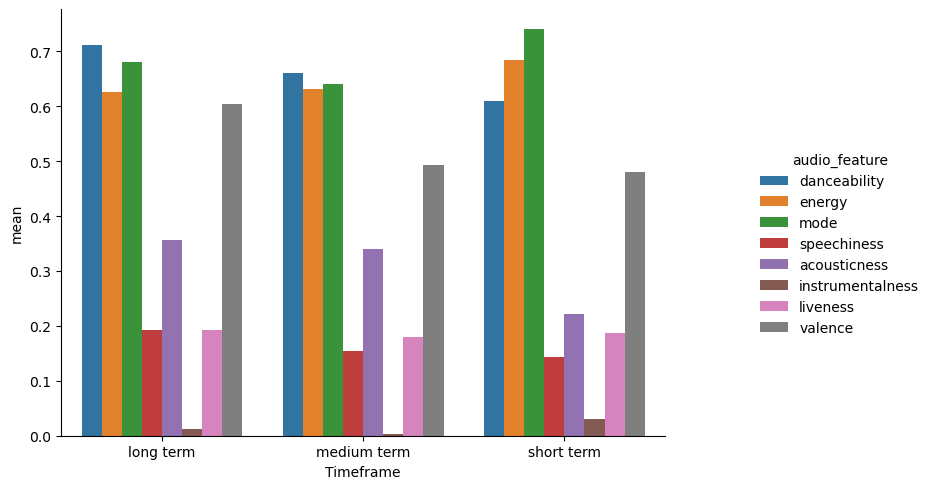

In [65]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data = plot_df, kind = "bar", x = "Timeframe",
            y = "mean", hue = "audio_feature"
)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()